In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.text import *

## Creating the DataBunch for the language model

At first, getting the csv file with the texts.

In [3]:
! git clone https://github.com/thiagodma/Similarity-ANEEL

Cloning into 'Similarity-ANEEL'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 123 (delta 36), reused 44 (delta 16), pack-reused 55
Receiving objects: 100% (123/123), 38.92 MiB | 9.25 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [4]:
df = pd.read_csv('Similarity-ANEEL/LanguageModelFile.csv', delimiter='|')
df.head()

,Unnamed: 0,Norma,Data de publicação,Ementa,Órgão de origem,Assuntos,Texto Integral,Tipo,Filename,Texto Extraído
0,0,INA - INSTRUÇÃO ADMINISTRATIVA 001/2019,05/04/2019,"Dispõe sobre procedimentos para atualização, m...",SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2019001sgi.pdf,INA,ina2019001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
1,1,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,25/05/2018,Dispõe sobre procedimentos para a manutenção d...,SGI/ANEEL,Procedimento \n,http://www2.aneel.gov.br/cedoc/ina2018001sgi.pdf,INA,ina2018001sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
2,2,INA - INSTRUÇÃO ADMINISTRATIVA 001/2018,04/05/2018,Altera o limite do valor de reembolso relativo...,SRH/ANEEL,Alteração \n,http://www2.aneel.gov.br/cedoc/ina2018001srh.pdf,INA,ina2018001srh.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...
3,3,INA - INSTRUÇÃO ADMINISTRATIVA 002/2019,20/05/2019,Dispõe sobre a composição e o funcionamento do...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019002sgi.pdf,INA,ina2019002sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA ANEEL ...
4,4,INA - INSTRUÇÃO ADMINISTRATIVA 003/2019,13/09/2019,Dispõe sobre a definição de acrônimos das coor...,SGI/ANEEL,Fixação \n,http://www2.aneel.gov.br/cedoc/ina2019003sgi.pdf,INA,ina2019003sgi.pdf,AGÊNCIA NACIONAL DE ENERGIA ELÉTRICA - ANEEL ...


In [5]:
df.isnull().sum()

Unnamed: 0            0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        1
dtype: int64

Here it was identified that exist NaN cells in the DataFrame, whose colunms should be stripped.

In [6]:
df = df.dropna()
df.isnull().sum()

Unnamed: 0            0
Norma                 0
Data de publicação    0
Ementa                0
Órgão de origem       0
Assuntos              0
Texto Integral        0
Tipo                  0
Filename              0
Texto Extraído        0
dtype: int64

In [0]:
df.to_csv(r'./LanguageModelFile.csv', sep='|')

In [0]:
data_lm = TextLMDataBunch.from_csv('.','LanguageModelFile.csv',delimiter='|',text_cols='Texto Extraído',label_cols='Assuntos')
# The first two parameters are the path to the csv (current directory) and the csv name.

#data_lm.save('data_lm')

In [9]:
data_lm.show_batch()

idx,text
0,"geral xxup da xxup agência xxup nacional xxup de xxup energia xxup elétrica xxup aneel , no uso de suas atribuições regimentais , de acordo com deliberação da xxmaj diretoria , tendo em vista o disposto no art . 2º da xxmaj lei nº 9.427 , de 26 de dezembro de 1996 , na xxmaj resolução xxmaj normativa no 414 , de 9 de setembro de 2010 , nos xxmaj"
1,"em nenhuma hipótese , a revogação da autorização acarretará , para a xxup aneel , qualquer responsabilidade em relação aos encargos , ônus , obrigações ou compromissos assumidos pela xxmaj autorizada com relação a terceiros , inclusive àquelas relativas aos seus empregados . xxmaj art . 6o xxmaj aplicam - se à xxmaj autorização de que trata o art . 2o desta xxmaj resolução , no que couber , as"
2,xxmaj resolução no 650 26 / 12 / 2001 xxmaj são xxmaj bernardo xxunk xxmaj caeté xxmaj empreendimentos xxmaj energéticos xxmaj ltda . xxmaj resolução no 524 03 / 12 / 2001 xxmaj senador xxmaj xxunk xxmaj pinheiro xxunk xxmaj centrais xxmaj elétricas da xxmaj mantiqueira xxup cem xxmaj resolução no 606 05 / 11 / 2002 xxmaj arvoredo xxunk xxmaj centrais xxmaj elétricas da xxmaj mantiqueira xxup cem xxmaj
3,"xxmaj xxunk , xxmaj xxunk , xxmaj marabá xxmaj paulista , xxmaj xxunk , xxmaj xxunk , xxmaj meridiano , xxmaj xxunk , xxmaj xxunk xxmaj estrela , xxmaj xxunk , xxmaj mirante do xxmaj paranapanema , xxmaj mogi - xxmaj guaçu , xxmaj mogi - xxmaj mirim , xxmaj xxunk , xxmaj monte xxmaj xxunk ( somente os distritos de xxmaj itaúba e xxmaj junqueira ) , xxmaj monte"
4,"xxunk xxunk 65,31 57,70 xxup cpee xxup quadro g xxup tarifa xxup de xxup ultrapassagem xxup horo - xxup sazonal xxup verde xxup demanda ( xxup r$ / kw ) xxup subgrupo xxup período xxup seco xxup ou xxup úmido xxmaj a3a ( 30 a 44 kv ) 21,62 xxup a4 ( 2,3 a 25 kv ) 20,00 xxup as ( xxmaj subterrâneo ) 30,68 xxup cpee xxup quadro i"


In [0]:
data_lm.save('data_lm')

## Training the Language Model

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


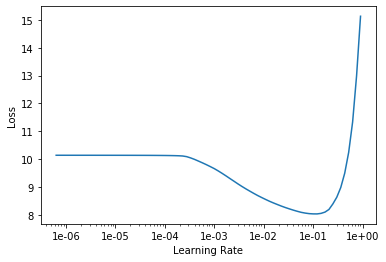

In [12]:
learn_lm.lr_find()
learn_lm.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,2.516972,2.460955,0.551054,05:11
1,1.989316,2.143403,0.591101,05:13
2,1.816209,1.875489,0.632740,05:12
3,1.648240,1.793020,0.648919,05:12


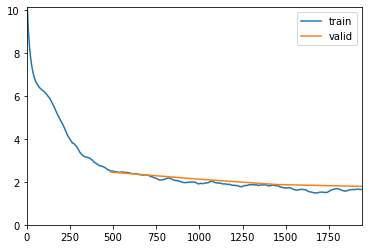

Better model found at epoch 0 with accuracy value: 0.5510535836219788.
Better model found at epoch 1 with accuracy value: 0.5911008715629578.
Better model found at epoch 2 with accuracy value: 0.6327400207519531.
Better model found at epoch 3 with accuracy value: 0.6489194631576538.


In [15]:
max_lr = 1e-2
learn_lm.fit_one_cycle(4, max_lr=max_lr, moms=(0.8,0.7), callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm')])

In [0]:
#Load the best version of the language model
learn_lm.load('learn_lm')
learn_lm.save_encoder('enc')

In [17]:
#Seeing what kind of text it generates
print(learn_lm.predict('Art. 1º Esta resolução visa',n_words=200,temperature=0.8))

Art. 1º Esta resolução visa retificada o fornecimento de energia elétrica a ser recebida pela Centrais Elétricas do Sul do Brasil s / A. - ELETRONORTE , para a empresa Eletrowind S.A. , com a vigência da Resolução no 073 , de 20 de janeiro de 1999 . Art . 4o Determinar que a Geradora Termelétrica S.A. - Filial Porto Alegre a estabelecer - se como Produtor Independente de Energia Elétrica mediante a implantação da central termelétrica , mediante a instalação de um turbogerador a vapor da usina em duas unidades geradoras , utilizando como combustível gás natural , localizada nas instalações industriais e sede da empresa . Art . 3º Autorizar a CAT - LEO Energia S.A. a estabelecer - se como Produtor Independente de Energia Elétrica , mediante a exploração da central geradora termelétrica Eólica Ombreiras , com sete unidades geradoras de 8.732 kw cada , totalizando a capacidade nominal de 850 kw para um final de 07 de abril de 1998 , conforme Autorização ANEEL , resolve


## Now, extracting the vector representation of the texts

In [0]:
#loading de list with all the texts that I want to get the representation
normas = list(pd.read_csv('Similarity-ANEEL/interesting_norms.csv',sep='|',encoding='utf-8')['Texto Extraído'])

In [0]:
data_lm = load_data('.',file='data_lm')
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult = 0.5, pretrained=False, callback_fns=ShowGraph)
learn_lm.load('learn_lm')

In [20]:
#Here I get the vector representation of the text using the trained encoder
mbe = MultiBatchEncoder(70,1400,learn_lm.model[0])

def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= output.size(1) / (output.size(1)-mask.type(avg_pool.dtype).sum(dim=1))[:,None]
    max_pool = output.masked_fill(mask[:,:,None], -float('inf')).max(dim=1)[0]
    x = torch.cat([output[:,-1], max_pool, avg_pool], 1)
    return x

X = np.zeros((1,1200))
i=0
for norma in normas:
    xb,yb = learn_lm.data.one_item(norma)
    sentence = torch.cuda.LongTensor(xb.tolist()[0]).unsqueeze(0)
    raw_outputs, outputs, masks = mbe.forward(sentence)
    sentence_rep = masked_concat_pool(outputs, masks)
    X = np.append(X,sentence_rep,axis=0)
    if i % 100 == 0: print(str(i+1) + ' out of ' + str(len(normas)))
    i+=1

1 out of 496
101 out of 496
201 out of 496
301 out of 496
401 out of 496


In [0]:
#the first row is the initialized as zeros, i dont need it
X = np.delete(X, (0), axis=0)

In [0]:
#save the texts repesentation in a file
np.save('X_LM', X)